In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
GPU_cuda_no = 0

cuda_no = 'cuda:'+str(GPU_cuda_no)

device = torch.device(cuda_no if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'META'
data = yf.download(ticker, period="5y")
prices = data['Close'].values
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-08-05  184.690002  185.669998  179.339996  181.729996  181.357315   
2019-08-06  183.690002  185.789993  183.089996  184.509995  184.131622   
2019-08-07  183.600006  186.369995  181.220001  185.149994  184.770294   
2019-08-08  186.619995  190.339996  184.050003  190.160004  189.770035   
2019-08-09  190.000000  190.979996  187.119995  187.850006  187.464783   

              Volume  
Date                  
2019-08-05  23086700  
2019-08-06  18035700  
2019-08-07  15833200  
2019-08-08  14828900  
2019-08-09  11058800  


In [4]:
window_size = 30
X, y = [], []
for i in range(len(prices) - window_size):
    X.append(prices[i:i+window_size])
    y.append(prices[i+window_size])
X, y = np.array(X), np.array(y)

In [5]:
X_train, y_train = torch.tensor(X[:-365], dtype=torch.float32), torch.tensor(y[:-365], dtype=torch.float32)
X_test, y_test = torch.tensor(X[-365:], dtype=torch.float32), torch.tensor(y[-365:], dtype=torch.float32)

In [6]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
class neuralNetworkOneLayer(nn.Module):
    def __init__(self):
        super(neuralNetworkOneLayer, self).__init__()
        self.fc1 = nn.Linear(window_size, 2*window_size)
        self.fc2 = nn.Linear(2*window_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
learning_rate = 0.001

In [10]:
OneLayer = neuralNetworkOneLayer() #.to(device)
criterion = nn.MSELoss() #.to(device)
optimizer = optim.Adam(OneLayer.parameters(), lr=learning_rate)

In [11]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

In [13]:
def calculate_accuracy(y_true, y_pred):
    return torch.mean(1 - torch.abs((y_true - y_pred) / y_true))

In [14]:
epochs = 500
for epoch in range(epochs):
    OneLayer.train()
    running_loss, running_acc = 0.0, 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = OneLayer(X_batch)
        loss = criterion(outputs, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        running_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    OneLayer.eval()
    running_val_loss, running_val_acc = 0.0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = OneLayer(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            running_val_loss += loss.item() * X_batch.size(0)
            running_val_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = running_val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch [1/500], Loss: 4831.8009, Val Loss: 1161.4831, Acc: 0.7759, Val Acc: 0.9202
Epoch [51/500], Loss: 83.9528, Val Loss: 132.1025, Acc: 0.9699, Val Acc: 0.9776
Epoch [101/500], Loss: 68.2172, Val Loss: 136.2200, Acc: 0.9732, Val Acc: 0.9758
Epoch [151/500], Loss: 62.2496, Val Loss: 94.8901, Acc: 0.9748, Val Acc: 0.9823
Epoch [201/500], Loss: 53.4788, Val Loss: 82.4842, Acc: 0.9769, Val Acc: 0.9836
Epoch [251/500], Loss: 81.6856, Val Loss: 79.8334, Acc: 0.9706, Val Acc: 0.9841
Epoch [301/500], Loss: 51.3124, Val Loss: 79.9813, Acc: 0.9780, Val Acc: 0.9841
Epoch [351/500], Loss: 50.4228, Val Loss: 79.5770, Acc: 0.9781, Val Acc: 0.9838
Epoch [401/500], Loss: 50.1548, Val Loss: 76.9595, Acc: 0.9778, Val Acc: 0.9844
Epoch [451/500], Loss: 55.6445, Val Loss: 76.6297, Acc: 0.9761, Val Acc: 0.9845
Epoch [500/500], Loss: 51.1723, Val Loss: 90.0003, Acc: 0.9778, Val Acc: 0.9824


In [15]:
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')
print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

Final Training Loss: 51.1723
Final Validation Loss: 90.0003
Final Training Accuracy: 0.9778
Final Validation Accuracy: 0.9824


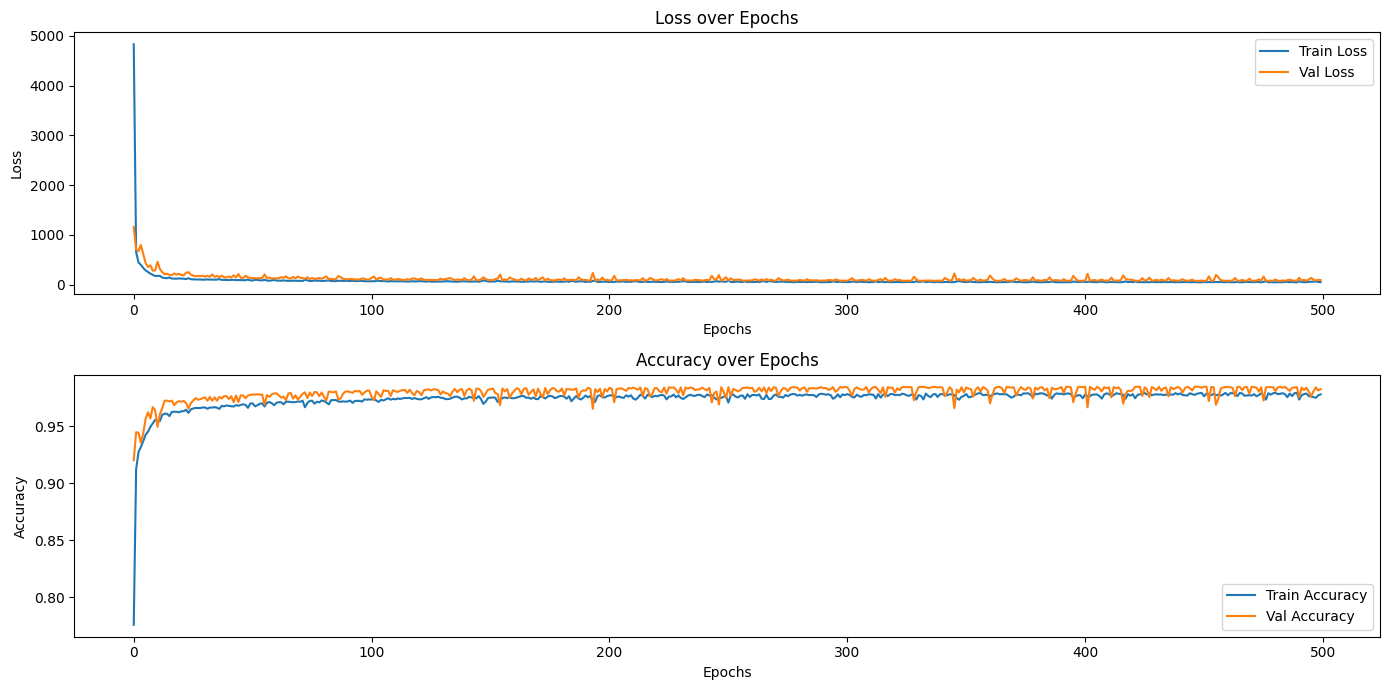

In [16]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


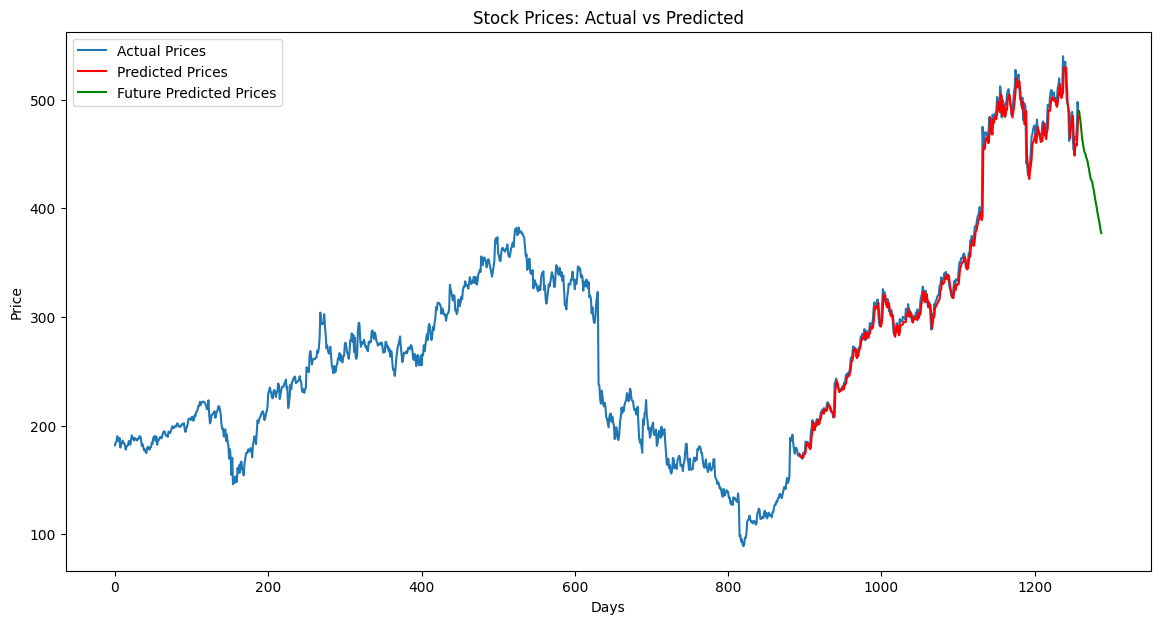

In [17]:
OneLayer.eval()
with torch.no_grad():
    future_days = 30
    future_prices = []
    input_seq = X_test[-1].numpy()
    for _ in range(future_days):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        predicted_price = OneLayer(input_tensor).item()
        future_prices.append(predicted_price)
        input_seq = np.append(input_seq[1:], predicted_price)
    

plt.figure(figsize=(14, 7))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(prices) - 365, len(prices)), OneLayer(X_test).detach().numpy(), label='Predicted Prices', color='red')
plt.plot(range(len(prices), len(prices) + future_days), future_prices, label='Future Predicted Prices', color='green')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Stock Prices: Actual vs Predicted')
plt.show()

In [18]:
class neuralNetworkThreeLayer(nn.Module):
    def __init__(self):
        super(neuralNetworkThreeLayer, self).__init__()
        self.fc1 = nn.Linear(window_size, 2*window_size)
        self.fc2 = nn.Linear(2*window_size, 4*window_size)
        self.fc3 = nn.Linear(4*window_size, window_size)
        self.fc4 = nn.Linear(window_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [19]:
ThreeLayer = neuralNetworkThreeLayer()
optimizer = optim.Adam(ThreeLayer.parameters(), lr=0.01)

In [20]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

In [21]:
epochs = 500
for epoch in range(epochs):
    ThreeLayer.train()
    running_loss, running_acc = 0.0, 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = ThreeLayer(X_batch)
        loss = criterion(outputs, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        running_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    ThreeLayer.eval()
    running_val_loss, running_val_acc = 0.0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = ThreeLayer(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            running_val_loss += loss.item() * X_batch.size(0)
            running_val_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)


    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = running_val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch [1/500], Loss: 4813.1437, Val Loss: 825.1305, Acc: 0.7966, Val Acc: 0.9455
Epoch [51/500], Loss: 75.0691, Val Loss: 119.4064, Acc: 0.9718, Val Acc: 0.9784
Epoch [101/500], Loss: 74.1853, Val Loss: 90.9389, Acc: 0.9719, Val Acc: 0.9826
Epoch [151/500], Loss: 97.6829, Val Loss: 83.1635, Acc: 0.9670, Val Acc: 0.9836
Epoch [201/500], Loss: 59.3200, Val Loss: 81.8601, Acc: 0.9754, Val Acc: 0.9837
Epoch [251/500], Loss: 67.2906, Val Loss: 94.3631, Acc: 0.9735, Val Acc: 0.9815
Epoch [301/500], Loss: 64.3517, Val Loss: 222.0572, Acc: 0.9743, Val Acc: 0.9656
Epoch [351/500], Loss: 70.9935, Val Loss: 198.8516, Acc: 0.9721, Val Acc: 0.9682
Epoch [401/500], Loss: 55.8627, Val Loss: 90.9512, Acc: 0.9760, Val Acc: 0.9823
Epoch [451/500], Loss: 53.3511, Val Loss: 82.3636, Acc: 0.9767, Val Acc: 0.9836
Epoch [500/500], Loss: 58.9925, Val Loss: 158.8110, Acc: 0.9760, Val Acc: 0.9728


In [22]:
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')
print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

Final Training Loss: 58.9925
Final Validation Loss: 158.8110
Final Training Accuracy: 0.9760
Final Validation Accuracy: 0.9728


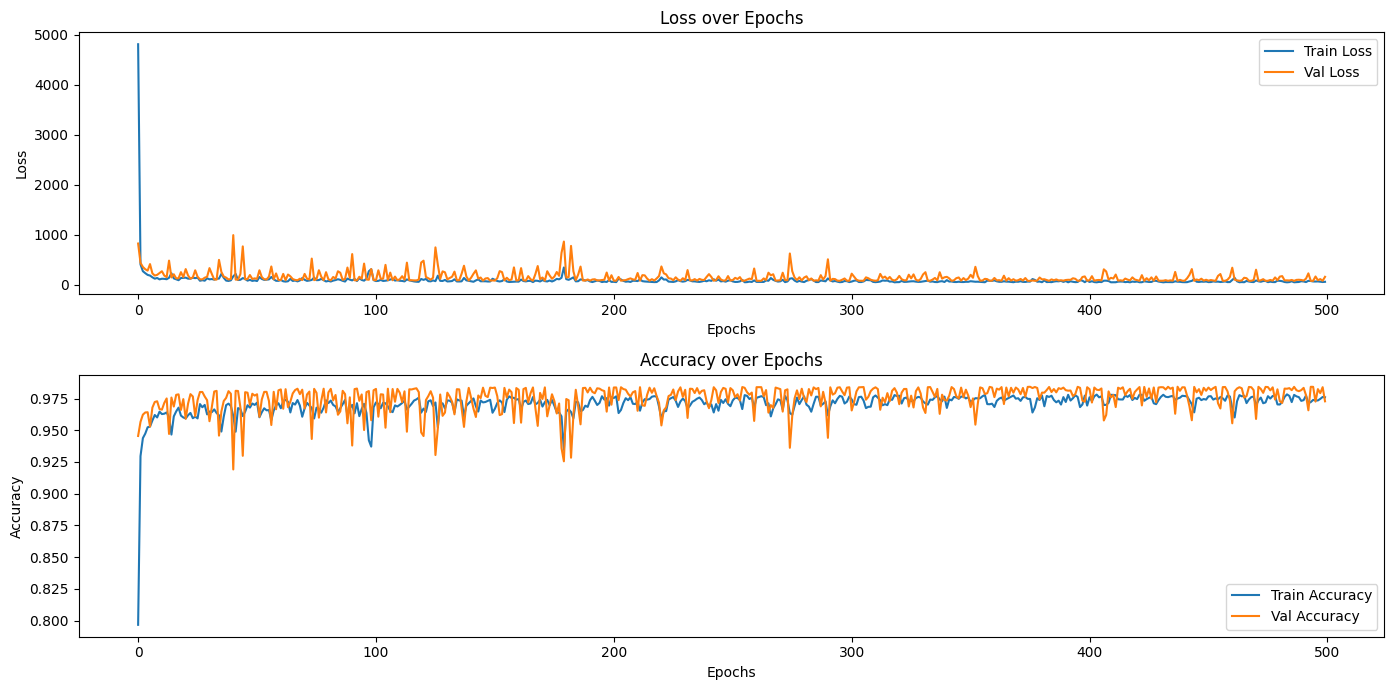

In [23]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

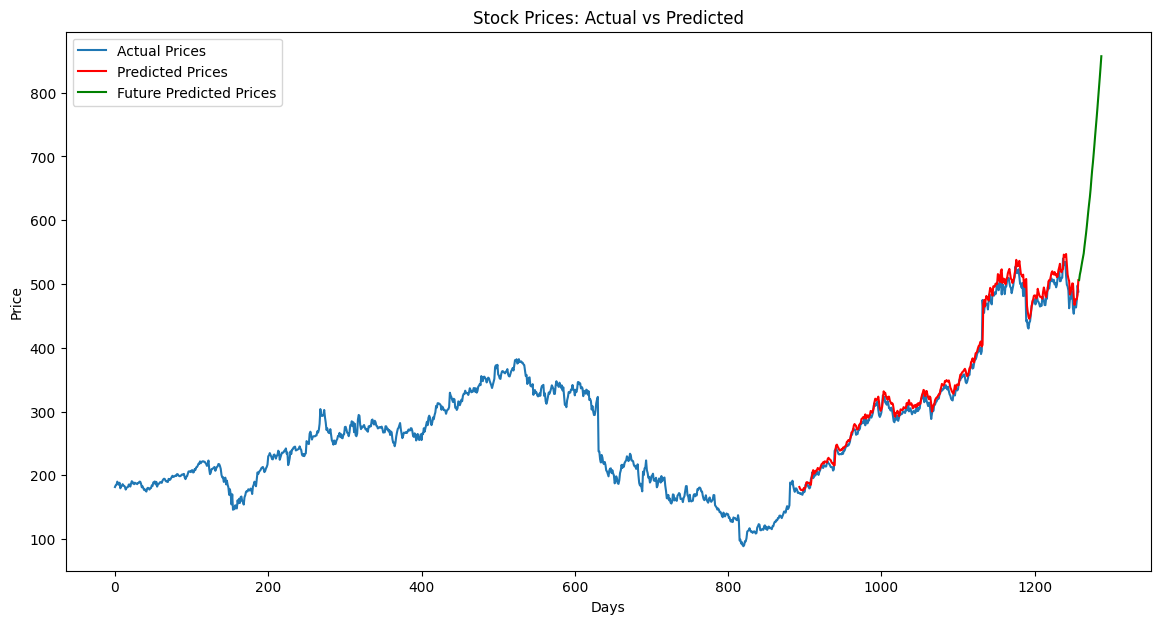

In [24]:
ThreeLayer.eval()
with torch.no_grad():
    future_days = 30
    future_prices = []
    input_seq = X_test[-1].numpy()
    for _ in range(future_days):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        predicted_price = ThreeLayer(input_tensor).item()
        future_prices.append(predicted_price)
        input_seq = np.append(input_seq[1:], predicted_price)
    

plt.figure(figsize=(14, 7))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(prices) - 365, len(prices)), ThreeLayer(X_test).detach().numpy(), label='Predicted Prices', color='red')
plt.plot(range(len(prices), len(prices) + future_days), future_prices, label='Future Predicted Prices', color='green')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Stock Prices: Actual vs Predicted')
plt.show()